This notebook processes the libraries of sorted CRTH2+ memory T cells, removes unwanted cells, and exports the data for Seurat

In [1]:
import pandas as pd
import numpy as np
import os
import time
import matplotlib.pyplot as plt
import matplotlib.backends
from matplotlib.backends.backend_pdf import PdfPages
from sklearn import linear_model
import anndata as an
import scipy
import feather



In [9]:
# Enter the name of your input file here
inputFile = "../PipelineInputFiles/sort_input.txt"
# Input parameters
nGene = 500
nCell = 0

try:
    os.stat("Sort_Plots")
except:
    os.mkdir("Sort_Plots")
    
# Read in DGE Files    
fileNames = pd.read_csv(inputFile, sep = "\t")
fileNames.head()

,Sample,DGE filePath,Reads filePath,Soup
0,1,L:\Duncan\eoepaper/DGEs/SortData/1_20200807_DG...,L:\Duncan\eoepaper/DGEs/SortData/1_20200807_re...,L:\Duncan\eoepaper/DGEs/SortData/1_20200807_so...
1,4,L:\Duncan\eoepaper/DGEs/SortData/4_20200917_DG...,L:\Duncan\eoepaper/DGEs/SortData/4_20200917_re...,L:\Duncan\eoepaper/DGEs/SortData/4_20200917_so...
2,5,L:\Duncan\eoepaper/DGEs/SortData/5_20200916_DG...,L:\Duncan\eoepaper/DGEs/SortData/5_20200916_re...,L:\Duncan\eoepaper/DGEs/SortData/5_20200916_so...
3,10,L:\Duncan\eoepaper/DGEs/SortData/10_20200917_D...,L:\Duncan\eoepaper/DGEs/SortData/10_20200917_r...,L:\Duncan\eoepaper/DGEs/SortData/10_20200917_s...
4,6,L:\Duncan\eoepaper/DGEs/SortData/6_20200917_DG...,L:\Duncan\eoepaper/DGEs/SortData/6_20200917_re...,L:\Duncan\eoepaper/DGEs/SortData/6_20200917_so...


In [11]:
tic = time.time()
first = True
for i in range(0, len(fileNames)):
        
    # read and print sample name
    sampName = fileNames.Sample.iloc[i]
    print(sampName)
        
    # read in DGE and readCounts files, calculate nUMI
    cells = pd.read_csv(fileNames.values[i,1], index_col = 0, header = 0, delim_whitespace = True)
    nUMIs = cells.sum(axis = 0)
    readCounts = pd.read_csv(fileNames.values[i,2], index_col = 0, header = 0, delim_whitespace = True)
    readCounts = readCounts.reindex(index = list(cells))
    cells.index = cells.index.str.upper()
    cells = cells.loc[~cells.index.duplicated(),:]    
    cells
        
    # plotting 
    spam = plt.figure()
    plt.rcParams['figure.figsize'] = [7,8]
    plt.plot(readCounts['ExonReads'], nUMIs, 'ko')
    plt.xlabel('Total Reads')
    plt.ylabel('Number of UMIs')
    plt.title(sampName + " Complexity")  
    regr = linear_model.LinearRegression()
    regr.fit(X = nUMIs.values.reshape(-1,1), y = readCounts['ExonReads'].values)
    plt.plot(X = nUMIs.values.reshape(-1,1), Y = regr.predict(nUMIs.values.reshape(-1,1)))
    c = np.array2string(regr.coef_[0])
    plt.annotate("Complexity = " + c, (0,plt.ylim()[1]*.95))
    plt.savefig(fname = "Sort_Plots/" + sampName + '.png')
    plt.close()
        
    # filter by nGene
    keepcells = (cells.values>0).sum(axis = 0) > nGene
    keepgenes = (cells.values > 0).sum(axis = 1) > nCell
    cells = cells.loc[keepgenes, keepcells]
        
    readCounts = readCounts[:][keepcells]
    n = cells.shape[1]

    # rename columns of data frame to prevent barcode collisions
    identsadd = [sampName]*n
    index = [identsadd[i] + "_" + str(i) for i in range(0, len(identsadd))]
    cells.columns = index
    bcs = readCounts.index.values
    print(len(bcs))
    
    if first:
        cellsAll = cells.copy()
        readCountsAll = readCounts.copy()
        bcsAll= bcs.copy()
        first = False
        idents_all = identsadd

    else:
        cellsAll = pd.DataFrame.join(cellsAll, cells, how = 'outer')
        readCountsAll = readCountsAll.append(readCounts)
        bcsAll = np.append(bcsAll, bcs)
        idents_all = np.append(idents_all, identsadd)
        
toc = time.time()
print(toc - tic)
cellsAll = cellsAll.fillna(0)
cellsAll = cellsAll.reset_index()
feather.write_dataframe(cellsAll, '../Data/sort_cellsAll.feather')  
feather.write_dataframe(readCountsAll, '../Data/sort_readCountsAll.feather')
np.savetxt('../Data/sort_bcs.txt', bcsAll, fmt = "%s")


1
559
4
2157
5
2072
10
1373
6
3789
11
861
12
4839
7
525
8
297
9
4183
13
2032
14
953
15
4029
16
472
17
256
18
1930
19
801
2
1039
20
3541
21
2770
22
2191
23
754
24
1031
25
4244
26
4328
3
609
PN1
1112
PN2
797
PN3
4235
2960.5177204608917


In [12]:
import sys
sys.path.append('../')
from functions import *

# read in and fix data
cells = pd.read_feather('../Data/sort_cellsAll.feather')
cells.index = cells.loc[:, 'Gene']
cells = cells.drop('Gene', axis = 1)

filtered out 7519 genes that are detectedin less than 3 cells
normalizing by total count per cell
    finished (0:00:19): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
extracting highly variable genes
    Gene indices [13581, 17598] fell into a single bin: their normalized dispersion was set to 1.
    Decreasing `n_bins` will likely avoid this effect.
    finished (0:00:53)
regressing out n_counts


... storing 'bcs' as categorical
... storing 'orig.ident' as categorical


    finished (0:02:19)
linear scaling
computing PCA with n_comps = 50
    finished (0:00:08)
    and added
    'X_pca', the PCA coordinates (adata.obs)
    'PC1', 'PC2', ..., the loadings (adata.var)
    'pca_variance', the variance / eigenvalues (adata.uns)
    'pca_variance_ratio', the variance ratio (adata.uns)
computing neighbors
    computing neighbors
    using 'X_pca' with n_pcs = 20


C:\Users\dmorgan\AppData\Local\Continuum\anaconda3\envs\seqwell\lib\site-packages\numba\compiler.py:602: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "C:\Users\dmorgan\AppData\Local\Continuum\anaconda3\envs\seqwell\lib\site-packages\umap\rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  self.func_ir.loc))
C:\Users\dmorgan\AppData\Local\Continuum\anaconda3\envs\seqwell\lib\site-packages\numba\compiler.py:602: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.htm

    computed neighbors (0:01:03)
    computed connectivities (0:00:15)
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:01:19)
computing UMAP
	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:02:04)
running Leiden clustering
    finished: found 17 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:02:44)


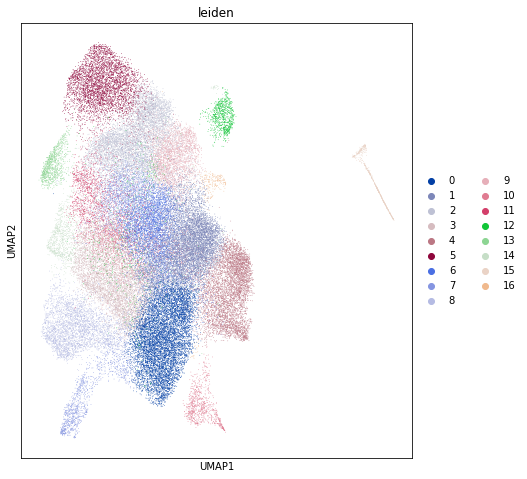

In [13]:
# SCANPY
sc.settings.verbosity = 4
adata = an.AnnData(cells.values.transpose())
adata.var_names = cells.index
adata.obs_names = cells.columns
bcs = np.loadtxt('../Data/sort_bcs.txt', dtype = str)
adata.obs['bcs']= bcs
adata.obs['orig.ident'] = idents_all
adata.obs_names_make_unique()
adata.var_names_make_unique()
adata

sc.pp.filter_genes(adata, min_cells = 3)
sc.pp.filter_cells(adata, min_genes = nGene)
adata

sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)
adata.raw = adata

adata = process(adata)


In [18]:
# fill out metadata
df = pd.read_csv('../PipelineInputFiles/samples.txt', sep = '\t', index_col = 0)
adata.obs['Patient'] = [df.Patient.loc[x] for x in adata.obs['orig.ident']]
adata.obs['Fraction'] = [df.Fraction.loc[x] for x in adata.obs['orig.ident']]
adata.obs['Diagnosis'] = [df.Diagnosis.loc[x] for x in adata.obs['orig.ident']]

... storing 'Patient' as categorical
... storing 'Fraction' as categorical
... storing 'Diagnosis' as categorical


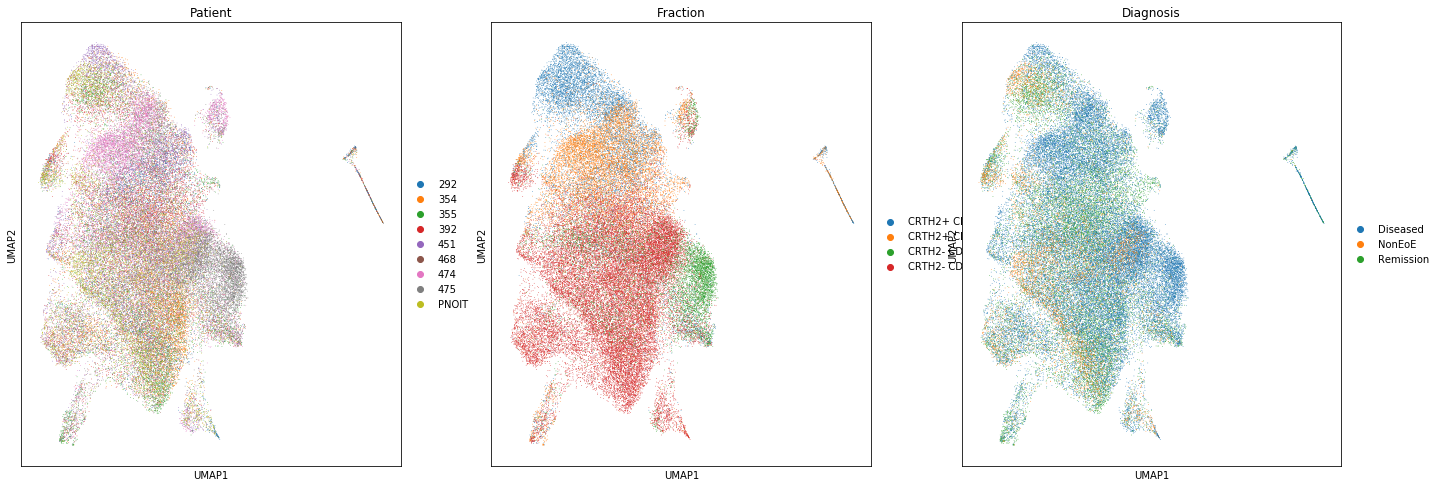

In [19]:
sc.pl.umap(adata, color= ['Patient', 'Fraction', 'Diagnosis'])

extracting highly variable genes
    Gene indices [13581, 17598] fell into a single bin: their normalized dispersion was set to 1.
    Decreasing `n_bins` will likely avoid this effect.
    finished (0:00:12)
regressing out n_counts
    finished (0:01:44)
linear scaling
computing PCA with n_comps = 50
    finished (0:00:04)
    and added
    'X_pca', the PCA coordinates (adata.obs)
    'PC1', 'PC2', ..., the loadings (adata.var)
    'pca_variance', the variance / eigenvalues (adata.uns)
    'pca_variance_ratio', the variance ratio (adata.uns)
computing neighbors
    computing neighbors
    using 'X_pca' with n_pcs = 20


C:\Users\dmorgan\AppData\Local\Continuum\anaconda3\envs\seqwell\lib\site-packages\numba\compiler.py:602: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "C:\Users\dmorgan\AppData\Local\Continuum\anaconda3\envs\seqwell\lib\site-packages\umap\nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  self.func_ir.loc))


    computed neighbors (0:00:36)
    computed connectivities (0:00:05)
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:42)
computing UMAP
	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:01:39)
running Leiden clustering
    finished: found 17 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:03:23)


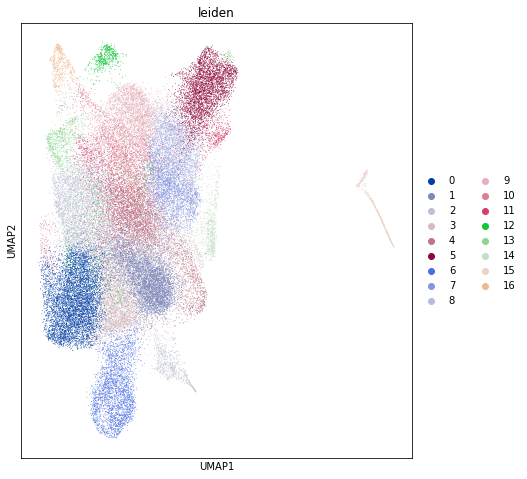

In [20]:
# remove CRTH2- CD161+ subset
adata2 = removecluster(adata, ['CRTH2- CD161+'], field = 'Fraction')

extracting highly variable genes
    Gene indices [13581, 17598] fell into a single bin: their normalized dispersion was set to 1.
    Decreasing `n_bins` will likely avoid this effect.
    finished (0:00:13)
regressing out n_counts
    finished (0:01:44)
linear scaling
computing PCA with n_comps = 50
    finished (0:00:04)
    and added
    'X_pca', the PCA coordinates (adata.obs)
    'PC1', 'PC2', ..., the loadings (adata.var)
    'pca_variance', the variance / eigenvalues (adata.uns)
    'pca_variance_ratio', the variance ratio (adata.uns)
computing neighbors
    computing neighbors
    using 'X_pca' with n_pcs = 20


C:\Users\dmorgan\AppData\Local\Continuum\anaconda3\envs\seqwell\lib\site-packages\numba\compiler.py:602: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "C:\Users\dmorgan\AppData\Local\Continuum\anaconda3\envs\seqwell\lib\site-packages\umap\nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  self.func_ir.loc))


    computed neighbors (0:00:43)
    computed connectivities (0:00:07)
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:51)
computing UMAP
	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:02:10)
running Leiden clustering
    finished: found 17 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:02:53)


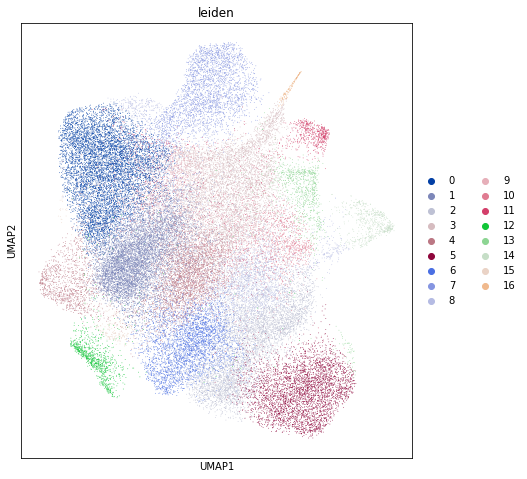

In [26]:
# remove the B cells + Naive T cells
adata3 = removecluster(adata2, ['15'])

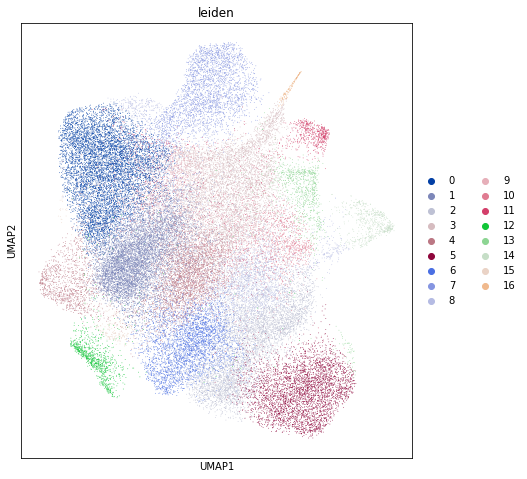

In [30]:
# since this is all T cells we can go ahead and clean it up before exporting
sc.pl.umap(adata3, color = 'leiden')

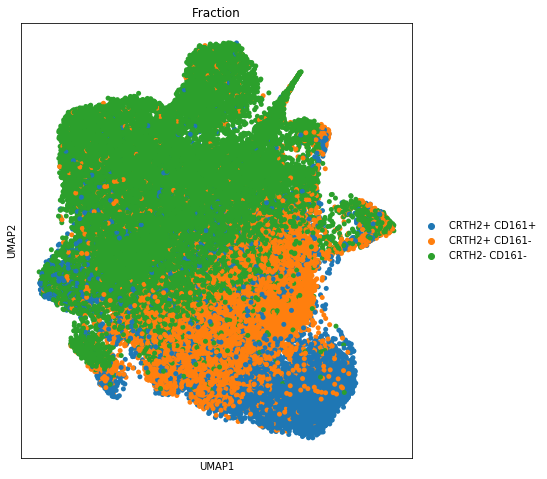

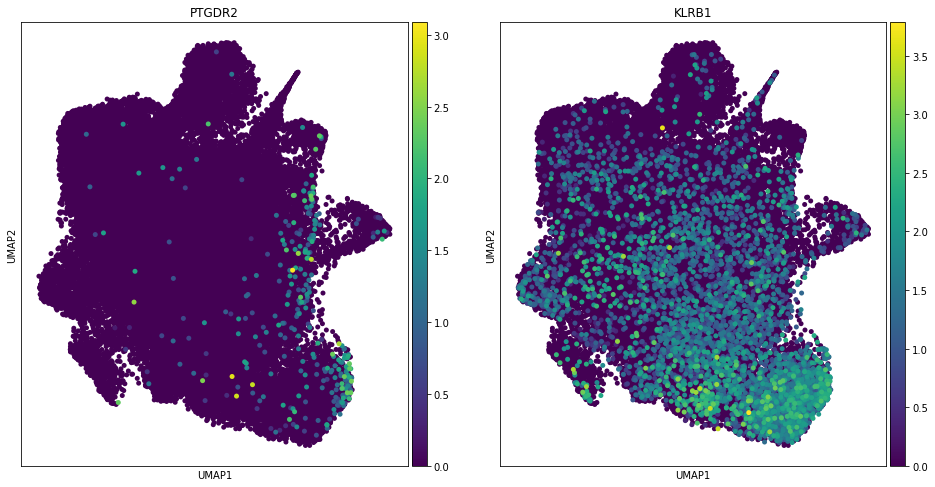

In [33]:
sc.pl.umap(adata3, color = 'Fraction', size = 100)
sc.pl.umap(adata3, color = ['PTGDR2', 'KLRB1'], size = 100)

running Leiden clustering
    finished: found 9 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:02:49)


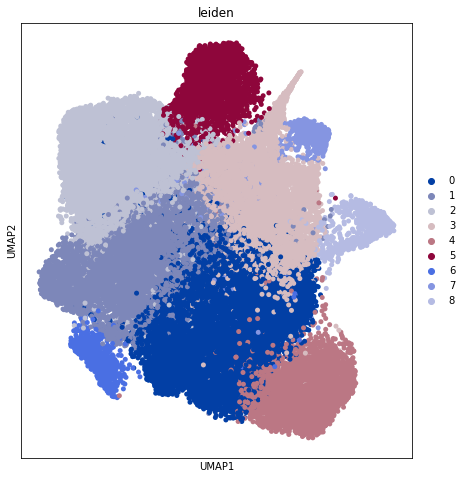

In [37]:
sc.tl.leiden(adata3, resolution = .4)
sc.pl.umap(adata3, color = 'leiden', size = 100)

In [40]:
pickle.dump(adata3, file = open('../Data/sort_raw.pickle', 'wb'), protocol = 4)


In [6]:
seuratExport(adata3, '../Data/sort_raw')
